In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

Using TensorFlow backend.


[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16085409966852863622, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 45088768
 locality {
   bus_id: 1
 }
 incarnation: 15974713805796707184
 physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:02:00.0"]

In [2]:
def get_shuffled_splitted_data(path):
    df = pd.read_csv(path)

    # Shuffle and split data
    X_train, X_test, X_val = np.split(df.sample(frac=1), [int(.7*len(df)), int(.8*len(df))])
    
    # Pop labels and transform them to vectors
    y_train, y_test, y_val = X_train.pop("label"), X_test.pop("label"), X_val.pop("label")
    y_train, y_test, y_val = y_train.values.reshape((-1, 1)), y_test.values.reshape((-1, 1)), y_val.values.reshape((-1, 1))
    
    # Reshape the features for CNN
    X_train = X_train.as_matrix().reshape(X_train.shape[0], 1, 124, 124)
    X_test = X_test.as_matrix().reshape(X_test.shape[0], 1, 124, 124)
    X_val = X_val.as_matrix().reshape(X_val.shape[0], 1, 124, 124)
    
    # Norm data
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_test /= 255
    X_val /= 255
    
    # Convert labels to categorical values
    y_train = keras.utils.to_categorical(y_train, 2)
    y_test = keras.utils.to_categorical(y_test, 2)
    y_val = keras.utils.to_categorical(y_val, 2)
    
    return X_train, y_train, X_test, y_test, X_val, y_val
    
X_train, y_train, X_test, y_test, X_val, y_val = get_shuffled_splitted_data('../data/subset-3-HnzTnx.txt.csv')

In [3]:
with tf.device('/gpu:0'):

    import keras
    from keras.preprocessing.image import ImageDataGenerator
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Conv2D, MaxPooling2D, Cropping2D
    from keras import backend as K
    from keras.losses import categorical_crossentropy
    from keras.optimizers import Adadelta
    K.set_image_dim_ordering('th')

    batch_size = 40
    num_classes = 2
    epochs = 2

    # The data, shuffled and split between train and test sets:
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    print(X_val.shape[0], 'validation samples')

    model = Sequential()
    model.add(MaxPooling2D(pool_size=(20, 5), input_shape=(1, 124, 124)))
    model.add(Conv2D(16, kernel_size=(1, 1)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    model.add(Flatten())
    model.add(Dense(2))
    model.add(Dense(6))
    
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_val, y_val))

    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', test_score[0])
    print('Test accuracy:', test_score[1])
    
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print('Val loss:', val_score[0])
    print('Val accuracy:', val_score[1])

X_train shape: (5184, 1, 124, 124)
5184 train samples
741 test samples
1482 validation samples
Train on 5184 samples, validate on 1482 samples
Epoch 1/2
5184/5184 [==============================] - 7s - loss: 0.4743 - acc: 0.8019 - val_loss: 0.1800 - val_acc: 1.0000
Epoch 2/2
5184/5184 [==============================] - 2s - loss: 0.0722 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 1.0000
Test loss: 0.0265924617115
Test accuracy: 1.0
Val loss: 0.0289973762193
Val accuracy: 1.0


model.summary()

In [3]:
model.summary()

NameError: name 'model' is not defined

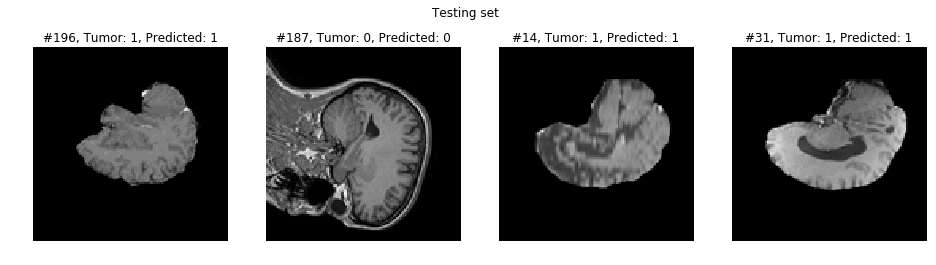

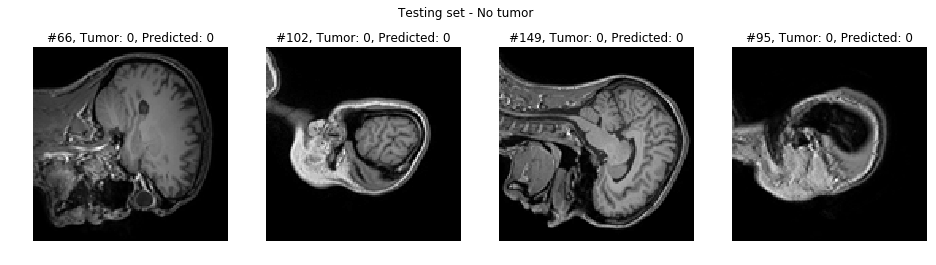

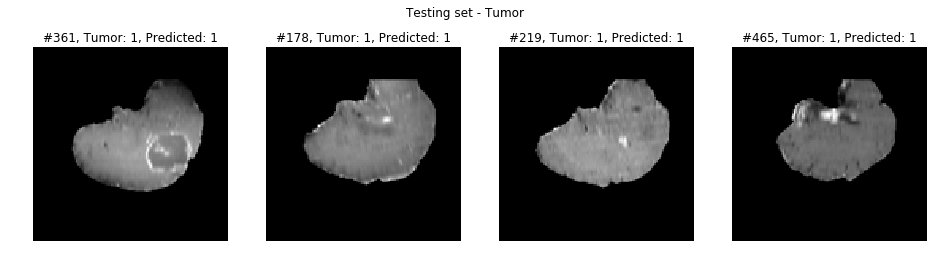

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot as plt
%matplotlib inline
# y_test_pred = model.predict(X_test, batch_size=32, verbose=0)
# y_test_pred = np.round(y_test_pred).astype(int)

def plot_sample(ax, sample, title):
    # The first line contains 65000 values for any reason
    img = sample.reshape(124, 124)[1:, 1:]
    ax.imshow(img, cmap='gray',  interpolation='nearest')
    ax.axis('off')
    ax.set_title(title)

def has_tumor(one_hot_vector):
    return one_hot_vector.argmax()
    
def plot_samples(count, samples, labels, predicted, main_title):
    # Shuffle datapoints
    idx = np.random.choice(np.arange(samples.shape[0]), count, replace=False)
    samples, labels, predicted = (samples[idx], labels[idx], predicted[idx])
    cols = 4
    rows = count // cols
    assert rows * cols == count, 'Number of samples must be a multiple of 4'
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
    for i, ax in enumerate(axes.flat):
        plot_sample(ax, samples[i], '#{}, Tumor: {}, Predicted: {}'.format(
            idx[i], has_tumor(labels[i]), has_tumor(predicted[i])))
    fig.suptitle(main_title)

# Always the same results
np.random.seed(0)
plot_samples(4, X_test, y_test, y_test, 'Testing set')
no_tumors = y_test.argmax(axis=1) == 0
plot_samples(4, X_test[no_tumors], y_test[no_tumors],
             y_test[no_tumors], 'Testing set - No tumor')
plot_samples(4, X_test[no_tumors == False], y_test[no_tumors == False],
             y_test[no_tumors == False], 'Testing set - Tumor')

# keras.utils.plot_model(model, show_shapes=True, to_file='model-Small-tk.png')
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))